# Bloque 4: Temas avanzados

In [3]:
%pylab
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


## Análisis de componentes principales (PCA)
El análisis de componentes principales (PCA, Principal Component Analysis) es una técnica no supervisada muy potente para la reducción de la dimensionalidad y extremadamente útil para la visualización de datos. PCA busca la dirección de los datos en la que se observa una mayor varianza. La mejor forma de ver la forma en que funciona PCA es mediante la creación de un conjunto de datos bidimensional.

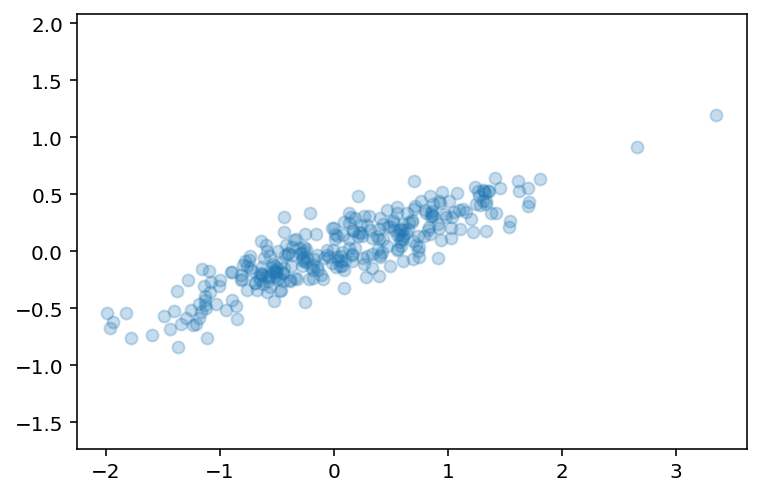

In [4]:
np.random.seed(1)
X = np.dot(np.random.random(size = (2, 2)), np.random.normal(size = (2, 300))).T
plot(X[:, 0], X[:, 1], 'o', alpha = 0.25)
axis('equal');

En la gráfica se puede ver que existe una tendencia definida en los datos. Lo que hace PCA es localizar los ejes principales de los datos y explicar cuán importantes son estos en la descripción de la distribución de los datos.

La componente 1 explica varianza 0.7793513744085954 y  es: [0.94625072 0.32343403]
La componente 2 explica varianza 0.020045222699058722 y  es: [-0.32343403  0.94625072]


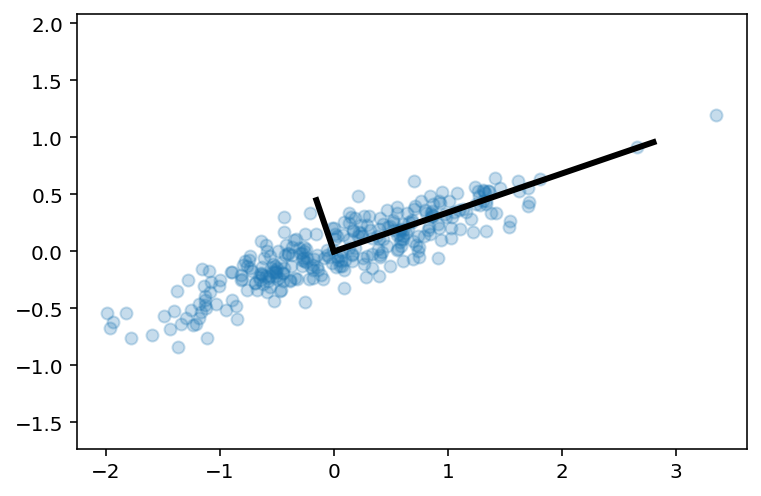

In [5]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2).fit(X)

for i in range(len(pca.explained_variance_)):
    print('La componente', i + 1, 'explica varianza', pca.explained_variance_[i],
          'y  es:', pca.components_[i])

plot(X[:, 0], X[:, 1], 'o', alpha = 0.25)

for length, vector in zip(pca.explained_variance_ratio_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    plot([0, v[0]], [0, v[1]], '-k', lw = 3)

axis('equal');

Obsérvese que un vector es más largo que el otro, esto indica que esta dirección es más importante que la otra. La varianza explicada es lo que cuantifica la importancia de la dirección. Ahora se puede observar el porcentaje de la varianza que explica la primera componente del conjunto de datos.

In [6]:
pca.explained_variance_ratio_[0] / sum(pca.explained_variance_ratio_)

0.974924558383679

La segunda componente se puede ignorar con la pérdida de un porcentaje de la información, para esto se puede seleccionar solamente el primer componente y transformarlos.

(300, 2)
(300, 1)
(300, 2)


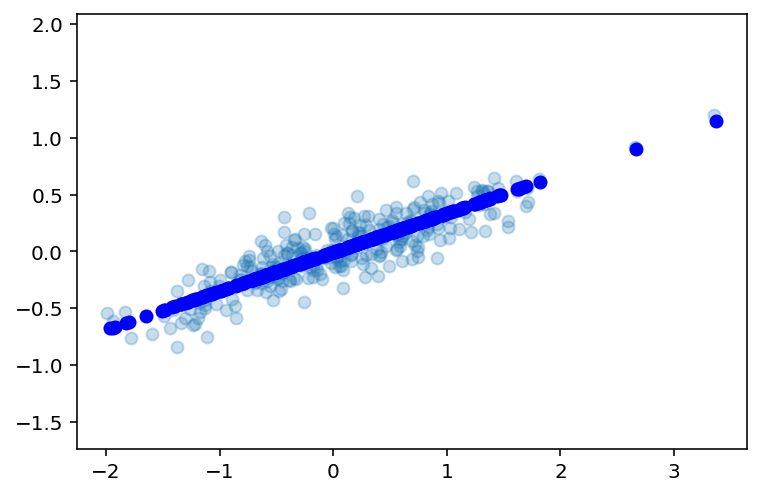

In [7]:
clf = PCA(n_components = 1)

X_trans = clf.fit_transform(X)

print(X.shape)
print(X_trans.shape)

X_new = clf.inverse_transform(X_trans)

print(X_new.shape)

plot(X[:, 0], X[:, 1], 'o', alpha = 0.25)
plot(X_new[:, 0], X_new[:, 1], 'ob', alpha=1)
axis('equal');

Los puntos claros son los datos originales, mientras que los puntos oscuros son los datos trasformados. En esta ocasión se ha conseguido comprimir los datos originales a un 50% de su tamaño con una pérdida de varianza de menos del 5%.

Esta es la forma en la que funciona PCA. En caso de que se pueda renunciar a un parte de la varianza de los datos eliminado una o más dimensiones se pueden obtener conjuntos de datos que se pueden visualizar mejor y adaptar a modelos más sencillos.

## Selección de modelos
A la hora de crear un modelo con alguna de las técnicas estudiadas en los diferentes bloques del módulo en muchas ocasiones es necesario seleccionar uno o varios parámetros. Para esto se puede utilizar las herramientas de validación cruzada que existen en la librería `model_selection` de *scikit-learn*.

Los datos utilizados hasta ahora son sintéticos, para probar estas técnicas se han de utilizar datos reales, para lo que se procede a la carga de un conjunto de datos de precios de la vivienda en Boston que se encuentran dentro de los ejemplos de *scikit-learn*.

In [6]:
from sklearn.datasets import load_boston

boston = load_boston()

En primer lugar, se puede generar un modelo con una regresión LASSO en la que se utiliza el parámetro `alpha` igual a 0,1.

In [7]:
from sklearn.linear_model import Lasso

model_ridge = Lasso(alpha = 0.1)
model_ridge.fit(boston.data, boston.target)

model_ridge.coef_

array([-0.09789363,  0.04921111, -0.03661906,  0.95519003, -0.        ,
        3.70320175, -0.01003698, -1.16053834,  0.27470721, -0.01457017,
       -0.77065434,  0.01024917, -0.56876914])

A priori no se puede saber el valor del parámetro `alpha` con el que se puede obtener el mejor modelo. Para eso se puede utilizar la función el objeto `GridSearchCV` con el cual se puede evaluar mediante validación cruzada los resultados para diferentes parámetros.

En las siguientes líneas se puede ver como comparar los modelos que se obtendrían con cinco valores diferentes de `alpha`.

In [8]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
from sklearn.model_selection import GridSearchCV

# Listado de alphas para ser evaluados
alphas = np.array([1, 0.1, 0.01, 0.001, 0.0001])

# Creación del modelo
model = Lasso()

# Selección del modelo
grid = GridSearchCV(estimator = model,
                    param_grid = dict(alpha = alphas),
                    cv = 10)
grid.fit(boston.data, boston.target)

# Los mejores parametros para el modelo
print('El mejor parametro es', grid.best_params_)
print('El mejor score es', grid.best_score_)

El mejor parametro es {'alpha': 0.1}
El mejor score es 0.2643273893487372


En el ejemplo anterior se ha podido comprobar que la mejor elección para el parámetro ` alpha` de la regresión LASSO es 0,1. Este procedimiento se puede utilizar para seleccionar varios parámetros a la vez. Por ejemplo, se puede comprobar si es mejor crear el modelo con termino de intersección o no, al mismo tiempo que se prueba el parámetro `alpha`.

In [10]:
fit_intercept = np.array([True, False])

# Selección del modelo
grid = GridSearchCV(estimator = model,
                    param_grid = dict(alpha = alphas,
                                      fit_intercept = fit_intercept),
                    cv = 10)
grid.fit(boston.data, boston.target)

# Los mejores parametros para el modelo
print('El mejor parametro es', grid.best_params_)
print('El mejor score es', grid.best_score_)

El mejor parametro es {'alpha': 0.1, 'fit_intercept': False}
El mejor score es 0.2954382356408133


El resultado para `alpha`es el mismo y se puede comprobar que el mejor modelo es aquel que no tiene termino de intersección.

En los ejemplos anteriores se ha buscado en el resultado en un conjunto predefinido de `alpha`. Por lo que podría no obtenerse el mejor resultado posible. Una alternativa es probar con valores aleatorios, para esto se puede utilizar el constructor `RandomizedSearchCV` junto al generador de números aleatorios `sp_rand`.

In [11]:
from scipy.stats import uniform as sp_rand
from sklearn.model_selection import RandomizedSearchCV

param_grid = dict(alpha = sp_rand())

rsearch = RandomizedSearchCV(estimator = model,
                             param_distributions = param_grid,
                             n_iter = 100,
                             cv = 10,
                             random_state = 1)
rsearch.fit(boston.data, boston.target)

# Los mejores parametros para el modelo
print('El mejor parametro es', rsearch.best_params_)
print('El mejor score es', rsearch.best_score_)

El mejor parametro es {'alpha': 0.31551563100606295}
El mejor score es 0.2757873079985179


El resultado muestra que es posible obtener un resultado mejor si se utiliza un valor de `alpha` no planteado en el conjunto de datos anterior. 

# Ensemble Learning
Hasta ahora se ha visto diferentes familias de modelos de aprendizaje automático que con los que se puede hacer predicciones. Ahora se va a ver la forma de combinar varios de estos modelos para hacer una predicción mejor. Esto es lo que se llama *Ensemble learning*.

Entre las principales téncias de Ensemble learning se pueden enumerar:
* **Voting**: Implementa diferentes tipos de modelos para obtener uno con mayor rendimiento.
* **Bagging** o **Pasting**: Implementa el mismo modelo con diferentes conjuntos de datos.
* **Boosting**: Los modelos se concentra en los registros que son difíciles de clasificar.

Para evaluar estos modelos se puede crear un conjunto de datos

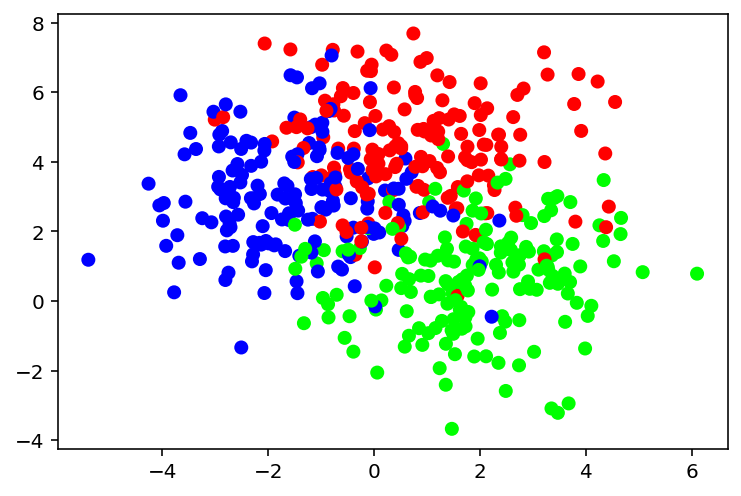

In [12]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap

X, y = make_blobs(500, 
                  centers=3, 
                  cluster_std=1.5,
                  random_state=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Version clara y oscura de los colores
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

scatter(X[:, 0], X[:, 1], c=y, cmap = cmap_bold)

## Voting
Los sistemas de votación buscan obtener un modelo mejor mediante la combinación de diferentes modelos. Para ello se entrena cada uno de los modelos para que realice una predicción y posteriormente decide por votación mayoritaria cual es la predicción para cada registro.

Esto se puede ver combinando varios modelos en el siguiente ejemplo:

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

log_clf = LogisticRegression(solver='lbfgs', multi_class='auto')
rnd_clf = RandomForestClassifier(n_estimators=4, random_state=0)
svm_clf = SVC(gamma='auto')
knn_clf = KNeighborsClassifier(10)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf),
                ('rf', rnd_clf),
                ('svc', svm_clf),
                ('knn', knn_clf)],
    voting='hard')

for clf in (log_clf, rnd_clf, svm_clf, knn_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.76
RandomForestClassifier 0.712
SVC 0.776
KNeighborsClassifier 0.776
VotingClassifier 0.784


En este caso se puede ver que la combinación de los cuatro modelos es ligeramente mejor que cada uno de forma independiente.

Ahora se puede ver visualmente como predice cada uno de los modelos por separada y en conjunto.

Text(0.5, 1.0, 'Voting')

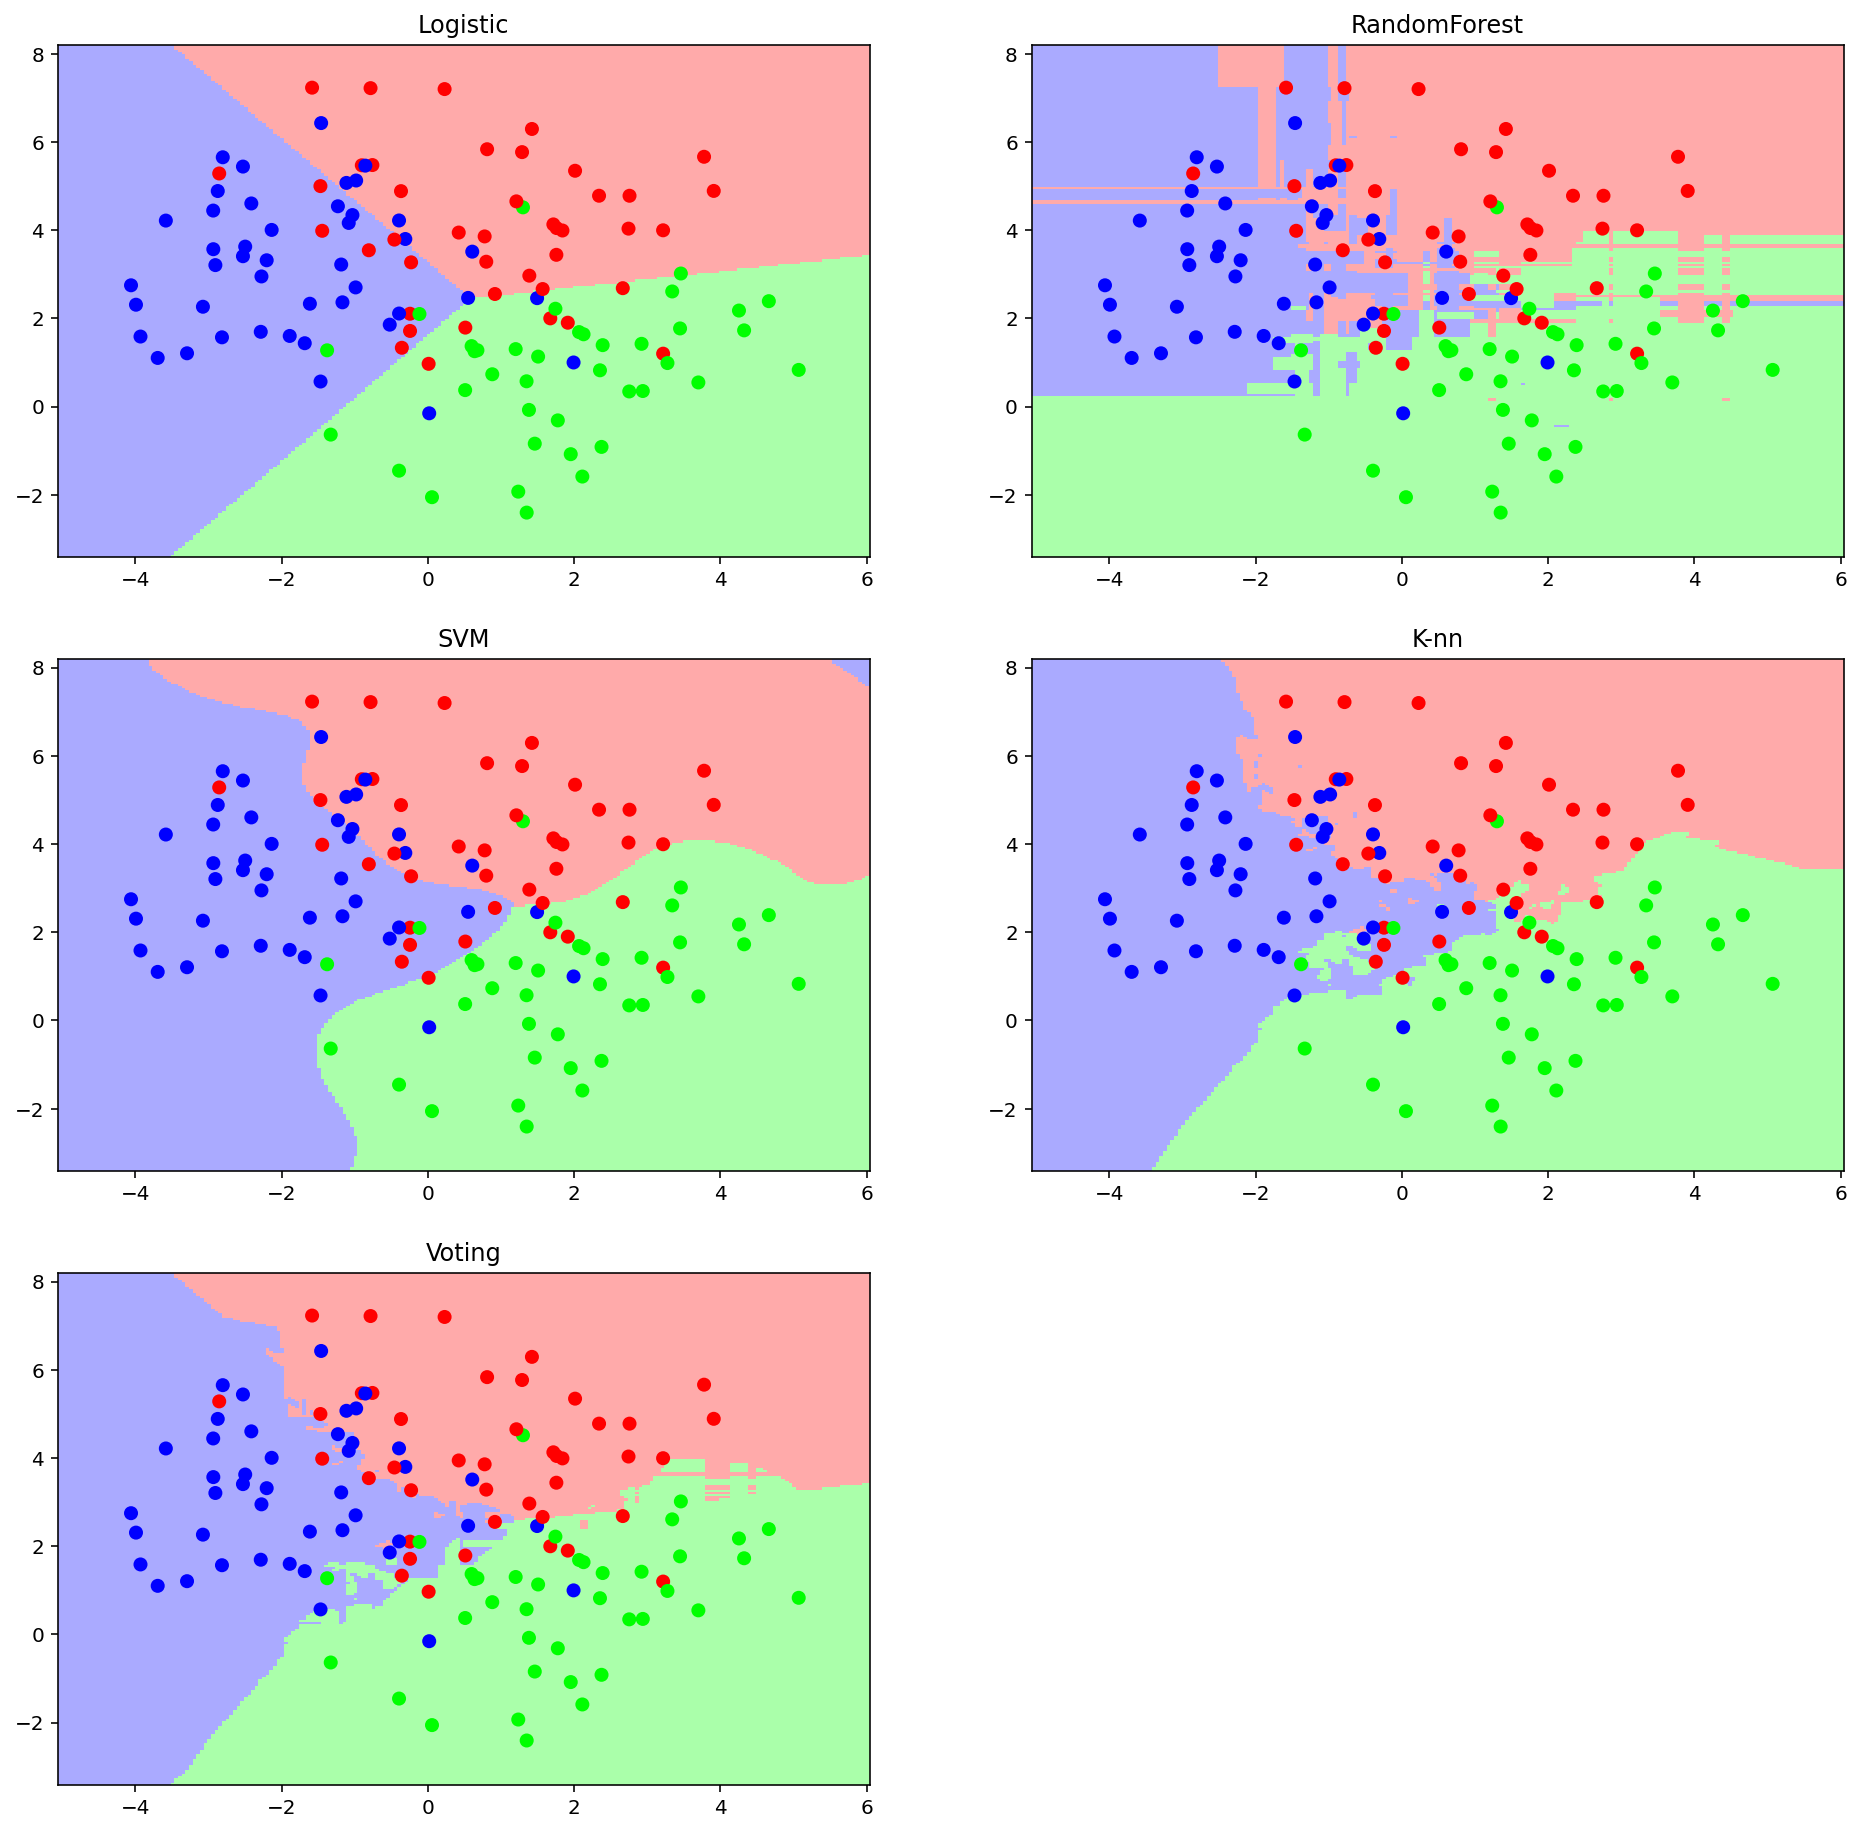

In [14]:
def plot_model(clf, X, y, border=1):
    # Version clara y oscura de los colores
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    # Creación de un conjunto de datos para 
    x_min, x_max = X[:, 0].min() - border, X[:, 0].max() + border
    y_min, y_max = X[:, 1].min() - border, X[:, 1].max() + border

    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05),
                         np.arange(y_min, y_max, 0.05))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    pcolormesh(xx, yy, Z, cmap = cmap_light)
    scatter(X[:, 0], X[:, 1], c=y, cmap = cmap_bold)
    xlim(xx.min(), xx.max())
    ylim(yy.min(), yy.max())

figure(figsize=(16, 16))
subplot(3, 2, 1)
plot_model(log_clf, X_test, y_test)
title('Logistic')
subplot(3, 2, 2)
plot_model(rnd_clf, X_test, y_test)
title('RandomForest')
subplot(3, 2, 3)
plot_model(svm_clf, X_test, y_test)
title('SVM')
subplot(3, 2, 4)
plot_model(knn_clf, X_test, y_test)
title('K-nn')
subplot(3, 2, 5)
plot_model(voting_clf, X_test, y_test)
title('Voting')

La votación se puede hacer de dos formas 
* *hard*: se pide la a cada uno de los modelos una predicción con la clase a la que pertenece cada registro y se usa este valor.
* *soft*:  se pide la probabilidad de que un registro pertenezca a cada clase, obteniéndose una predicción ponderada de los clasificadores.

La clasificación *soft* requiere que el clasificador tenga el método `predic_proba`, algo que por defecto no tiene el clasificador `SVC`. Así se puede probar un modelo sin este clasificador:

In [15]:
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf),
                ('rf', rnd_clf),
                ('knn', knn_clf)],
    voting='soft')

for clf in (log_clf, rnd_clf, knn_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.76
RandomForestClassifier 0.712
KNeighborsClassifier 0.776
VotingClassifier 0.792


Volviendo a obtener un clasificador que es mejor que los clasificadores independientes.

## Bagging y Pasting
**Bagging** y **Pasting** combinan un mismo modelo pero que es entrenado con diferentes conjuntos de datos. Realizando la predicción por votación. La diferencia entre **Bagging** y **Pasting** es

* **Bagging**: el muestreo de los datos se realiza con reemplazo, es decir, a la hora de seleccionar un registro para un modelo este se puede volver a aparecer en el conjunto de datos. 
* **Pasting**: el muestreo de los datos se realiza sin reemplazo, es decir, a la hora de seleccionar un registro para un modelo este se puede volver a aparecer en el conjunto de datos. 

Un ejemplo de este tipo de modelos es Random Forest.

### Bagging
Tanto los modelos Bagging como Pasting se implementan con la clase `BaggingClassifier`. A continuación, se puede ver como usar esta clase para combinar árboles de decisión.

In [16]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=10,
    max_samples=100,
    bootstrap=True,
    random_state=0)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

accuracy_score(y_test, y_pred)

0.744

Ahora se puede ver como mejora el algoritmo al utilizar más clasificadores.

In [17]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=50,
    max_samples=100,
    bootstrap=True,
    random_state=0)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

accuracy_score(y_test, y_pred)

0.744

### Pasting
Para crear un modelo **Pasting** solamente se tiene que cambiar la opción `bootstrap` a `False`. Lo que se muestra en el siguiente ejemplo:

In [18]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=10,
    max_samples=100,
    bootstrap=False,
    random_state=0)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

accuracy_score(y_test, y_pred)

0.784

## Boosting
Los modelos de Boosting los modelos utilizados se concentran en los registros difíciles de clasificar. Entre las técnicas más conocidas se encuentran:

* AdaBoost
* Gradient Boosting

### Ada Boost
En *scikit-learn* un clasificador **AdaBoost** se implementa con la clase `AdaBoostClassifier`.

In [19]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=200,
    algorithm="SAMME.R",
    learning_rate=0.5)

ada_clf.fit(X_train, y_train)

y_pred = ada_clf.predict(X_test)

accuracy_score(y_test, y_pred)

0.72

### Gradient Boosting
En *scikit-learn* un clasificador **Gradient Boosting** se implementa con la clase `GradientBoostingRegressor`.

In [20]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)

gbrt.fit(X_train, y_train)

gbrt.fit(X_train, y_train)

y_pred = gbrt.predict(X_test) > 0.5

accuracy_score(y_test, y_pred)

0.472

# Selección de hiperparámetros

A la hora de crear un modelo es necesario ajustar múltiples hiperparámetros, el parámetro `alpha` en la regresión Lasso, `k` en los k-nn o el número de variables que se seleccionan en `SelectPercentile`. Estos hiperparámetros se pueden seleccionar con `GridSearchCV`.

Para comprobar se puede crear un conjunto de datos.

In [21]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(n_samples=2000,
                           n_features=20,
                           n_informative=18,
                           n_redundant=2,
                           random_state=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

Se puede comprobar cómo funcionan en una regresión Lasso con `alpha` igual a 0,01.

In [22]:
from sklearn.linear_model import Lasso

model = Lasso(alpha = 0.01)
model.fit(X_train, y_train)

model.coef_

array([-0.00570401,  0.04488384, -0.00209383, -0.02567281,  0.00627902,
       -0.04005877, -0.04462959, -0.02536484, -0.02167571,  0.        ,
        0.02800085, -0.00925625,  0.0376165 ,  0.        ,  0.        ,
        0.05264146,  0.00305893, -0.00342731, -0.06142395,  0.03109743])

O con `alpha` igual a 0,2.

In [23]:
model = Lasso(alpha = 0.2)
model.fit(X_train, y_train)

model.coef_

array([ 0.        ,  0.        , -0.        , -0.        , -0.        ,
       -0.00243515, -0.01565161, -0.00829372, -0.        , -0.00186629,
        0.        , -0.        ,  0.00572037,  0.00206846,  0.        ,
        0.00902963, -0.        ,  0.        , -0.03544102,  0.00350281])

Para seleccionar la mejor opción se puede usar ` GridSearchCV` el cual prueba automáticamente diferentes parámetros y los selecciona mediante validación cruzada.

In [24]:
from sklearn.model_selection import GridSearchCV

# Listado de alphas para ser evaluados
alphas = np.array([1, 0.7, 0.5, 0.2, 0.1, 0.01, 0.001])

# Creación del modelo
model = Lasso()

# Selección del modelo
grid = GridSearchCV(estimator = model,
                    param_grid = dict(alpha = alphas),
                    cv = 10)
grid.fit(X_train, y_train)

# Los mejores parametros para el modelo
print('El mejor parametro es', grid.best_params_)
print('El mejor score es', grid.best_score_)

El mejor parametro es {'alpha': 0.001}
El mejor score es 0.4090436608707437


Si es necesario se puede probar más de un hiperparámetro, por ejemplo, ver sin es mejor usar el termino independiente o no. 

In [25]:
fit_intercept = np.array([True, False])

# Selección del modelo
grid = GridSearchCV(estimator = model,
                    param_grid = dict(alpha = alphas,
                                      fit_intercept = fit_intercept),
                    cv = 10)
grid.fit(X_train, y_train)

# Los mejores parametros para el modelo
print('El mejor parametro es', grid.best_params_)
print('El mejor score es', grid.best_score_)

El mejor parametro es {'alpha': 0.001, 'fit_intercept': True}
El mejor score es 0.4090436608707437


Con lo que se puede comprobar que el mejor valor para `alpha` es 0,001 con termino independietne. En este caso se ha probado en un conjunto acotado de valores, pero tambien se puede probar con número aleatorios.

In [26]:
import warnings
from scipy.stats import uniform as sp_rand
from sklearn.model_selection import RandomizedSearchCV

warnings.filterwarnings('ignore')

param_grid = dict(alpha = sp_rand())

rsearch = RandomizedSearchCV(estimator = model,
                             param_distributions = param_grid,
                             n_iter = 30,
                             cv = 10,
                             random_state = 1)
rsearch.fit(X_train, y_train)

# Los mejores parametros para el modelo
print('El mejor parametro es', rsearch.best_params_)
print('El mejor score es', rsearch.best_score_)

El mejor parametro es {'alpha': 0.00011437481734488664}
El mejor score es 0.40899944003219835


Lo que nos da como solución un valor diferente a los probados anteriormente.

## Unión de `SelectPercentile` y `GridSearchCV`
Además de los hiperparámetros del modelo también es necesario definir los del preprocesado de datos. Por ejemplo, la selección de las mejores características como `SelectPercentile` u otras clases. Para ello se pueden usar tuberías para automatizar el proceso.

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_regression

pipeline = Pipeline([('kbest', SelectPercentile(f_regression)),
                     ('lasso', Lasso())])

param = {'kbest__percentile': [10, 20, 30, 40, 50, 60, 70, 80, 90],
         'lasso__alpha': [1, 0.1, 0.01, 0.001, 0.0001, 0]}

grid = GridSearchCV(pipeline,
                    param_grid = param,
                    cv = 10)
grid.fit(X_train, y_train)

print('El mejor parametro es', grid.best_params_)
print('El mejor score es', grid.best_score_)

El mejor parametro es {'kbest__percentile': 90, 'lasso__alpha': 0}
El mejor score es 0.40933502395146093


Con lo que se puede automatizar la selección de todos los hiperparámetros del flujo de trabajo.